# Introduction to geopandas for analyzing spatial data

[*Geopandas*](https://github.com/geopandas/geopandas) is an excellent extension to the [*Pandas*](https://github.com/pandas-dev/pandas) package for working with tabular data that is georeferenced - for example, Points, Lines, and Polygons that have associated attributes. Geopandas builds upon other great libraries including [*Shapely*](https://github.com/Toblerity/Shapely) and [*Fiona*](https://github.com/Toblerity/Fiona).

This notebook is intended as an introduction to Geopandas for the [Data Science for Social Good (DSSG 2018)](http://escience.washington.edu/get-involved/incubator-programs/data-science-for-social-good/) summer project.

There are a lot of tutorials out there: Check out this lesson from a [eScience DSSG tutorial](https://uwescience.github.io/SQL-geospatial-tutorial/) or the [eScience Geohackweek tutorial](https://geohackweek.github.io/vector/).



## This notebook covers the following topics:

* dataset exploration
* basic statistical analysis
* simple geometric operations (convex_hull)
* exporting data for GIS software
* converting coordinates and calculating distance and area
* attribute and spatial joins

In [27]:
# import all the libraries we are going to use
import pandas as pd
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
# First thing to note is that many geospatial python packages are under active development
# and updated regularly. So the version you're using today will likely be updated in the near 
# future!
print('Geopandas version: ', gpd.__version__)
print('Pandas version: ', gpd.pd.__version__)

Geopandas version:  0.4.1
Pandas version:  0.24.2


In [29]:
# Geopandas has convenient methods for reading tabluar data, in this case we have 2 CSV files:
!ls -lh ./Data/*csv

ls: ./Data/*csv: No such file or directory


In [30]:
# Note that the 'places' information has 9 columns with labels in the first row
!head Places_Full.csv

head: Places_Full.csv: No such file or directory


In [31]:
# And the distance data has information about transit between two places
!head Dist_Out.csv

head: Dist_Out.csv: No such file or directory


# Pandas review

In [32]:
# Let's work with the smaller 'Places_Full.csv' first
# All Pandas methods are accessed via the 'pd' attribute.
# Since the file is well-formatted, it is easily read into memory:
filePath = '../data/Places_Full.csv'
df = gpd.pd.read_csv(filePath)

In [33]:
# 'df' stands for 'Data Frame'. It is essentially a spreadsheet:
df.head()

,name,address,city,lat,lng,place_id,rating,class,type
0,Trader Joe's,1700 East Madison Street,Seattle,47.615866,-122.309913,ChIJx0M1ztNqkFQRtgspEllQxk8,4.5,supermarket,NaN
1,Hillcrest Market,110 Summit Avenue East,Seattle,47.618850,-122.325005,ChIJt5emCTMVkFQR-BCgFDTvu9o,3.5,supermarket,NaN
2,Uwajimaya,600 5th Avenue South,Seattle,47.596843,-122.326929,ChIJq9nX27xqkFQRu05rxkrN7f4,4.5,supermarket,NaN
3,Kress IGA Supermarket,1427 3rd Avenue,Seattle,47.609396,-122.337822,ChIJbdIhoLNqkFQRMTiHCN6W4nU,3.9,supermarket,NaN
4,Double Dorjee,1501 Pike Street # 511,Seattle,47.608822,-122.339570,ChIJkX3s-LJqkFQRQRexqCN0jQY,5.0,supermarket,NaN


In [34]:
# The dataframe has a lot of convenient methods for fast data exploration
# Start with info to confirm that things were read in correctly
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1616 entries, 0 to 1615
Data columns (total 9 columns):
name        1616 non-null object
address     1520 non-null object
city        1540 non-null object
lat         1616 non-null float64
lng         1616 non-null float64
place_id    1616 non-null object
rating      1449 non-null float64
class       1616 non-null object
type        15 non-null object
dtypes: float64(3), object(6)
memory usage: 113.7+ KB


In [35]:
# Simple statistics are obtained for numerical columns
df.describe()

,lat,lng,rating
count,1616.000000,1616.000000,1449.000000
mean,47.619907,-122.321132,4.194134
std,0.056363,0.049129,0.638952
min,47.455556,-122.411493,1.000000
25%,47.586566,-122.347183,3.900000
50%,47.614611,-122.328568,4.300000
75%,47.661334,-122.309480,4.600000
max,47.790207,-122.114213,5.000000


In [36]:
# Columns can be accessed as dictionary items:
print(df['city'].unique())
# Or accessed as attributes for faster typing:
print(df.city.unique())

['Seattle' 'Medina' 'Mercer Island' 'Shoreline' 'Edmonds' 'Tukwila'
 'Kenmore' 'Kirkland' 'Lake Forest Park' 'Bothell' 'Renton' 'Bellevue'
 'Newcastle' 'SeaTac' 'Burien' nan]
['Seattle' 'Medina' 'Mercer Island' 'Shoreline' 'Edmonds' 'Tukwila'
 'Kenmore' 'Kirkland' 'Lake Forest Park' 'Bothell' 'Renton' 'Bellevue'
 'Newcastle' 'SeaTac' 'Burien' nan]


In [37]:
# NOTE: seems there is bug in v 0.3 since the attribute 'class' 
# is reserved for internal use, but it is also a column heading
print(df['class'].unique())
#print(df.class.unique()) # This causes an error

['supermarket' 'library' 'hospital' 'pharmacy' 'post_office' 'school'
 'cafe' 'urban village' 'destination park' 'citywide']


In [38]:
# let's change the name of class to avoid that error
df.rename(columns={'class':'place_class'}, inplace=True)
df.place_class.unique()

array(['supermarket', 'library', 'hospital', 'pharmacy', 'post_office',
       'school', 'cafe', 'urban village', 'destination park', 'citywide'],
      dtype=object)

In [39]:
# Another common issue with tabular data - 
# certain measurements don't always fit into the defined columns 
# or are missing data, and therefore filled with 'not-a-number (nan)'
# For example, some entries don't have a listed city:
print(df.city.unique())


['Seattle' 'Medina' 'Mercer Island' 'Shoreline' 'Edmonds' 'Tukwila'
 'Kenmore' 'Kirkland' 'Lake Forest Park' 'Bothell' 'Renton' 'Bellevue'
 'Newcastle' 'SeaTac' 'Burien' nan]


In [40]:
# Extract data entries without a city
dfNan = df[df.city.isna()]
dfNan

,name,address,city,lat,lng,place_id,rating,place_class,type
1540,12th Avenue,NaN,NaN,47.608315,-122.317345,12th-Avenue,NaN,urban village,NaN
1541,23rd & Union-Jackson,NaN,NaN,47.603145,-122.306682,23rd-&-Union-Jackson,NaN,urban village,NaN
1542,Admiral,NaN,NaN,47.582350,-122.386420,Admiral,NaN,urban village,NaN
1543,Aurora-Licton Springs,NaN,NaN,47.696854,-122.345977,Aurora-Licton-Springs,NaN,urban village,NaN
1544,Ballard,NaN,NaN,47.670593,-122.382603,Ballard,NaN,urban village,NaN
1545,Ballard-Interbay-Northend,NaN,NaN,47.659726,-122.372020,Ballard-Interbay-Northend,NaN,urban village,NaN
1546,Belltown,NaN,NaN,47.614435,-122.347341,Belltown,NaN,urban village,NaN
1547,Bitter Lake Village,NaN,NaN,47.728560,-122.350653,Bitter-Lake-Village,NaN,urban village,NaN
1548,Capitol Hill,NaN,NaN,47.620316,-122.319866,Capitol-Hill,NaN,urban village,NaN
1549,Chinatown-International District,NaN,NaN,47.597980,-122.325308,Chinatown-International-District,NaN,urban village,NaN


# From Pandas to Geopandas

In [41]:
# Commonly, there at latitude, longitude columns for places, but we must tell geopandas 
# explicity what the geometries (Points) and coordinate reference is (EPSG:4326)
# https://geopandas.readthedocs.io/en/v0.3.0/projections.html#coordinate-reference-systems

# Once identified, we'll have a "Geodataframe (gf)":
geometries = [shapely.geometry.Point(xy) for xy in zip(df.lng, df.lat)]
print(geometries)
crs = {'init': 'epsg:4326'}
gf = gpd.GeoDataFrame(df, crs=crs, geometry=geometries)

[<shapely.geometry.point.Point object at 0x10c12e2e8>, <shapely.geometry.point.Point object at 0x10c12e358>, <shapely.geometry.point.Point object at 0x10c12e4a8>, <shapely.geometry.point.Point object at 0x10c12e438>, <shapely.geometry.point.Point object at 0x10c12e400>, <shapely.geometry.point.Point object at 0x10c12e0f0>, <shapely.geometry.point.Point object at 0x10c12e470>, <shapely.geometry.point.Point object at 0x10c12e4e0>, <shapely.geometry.point.Point object at 0x10c12e518>, <shapely.geometry.point.Point object at 0x10c12e550>, <shapely.geometry.point.Point object at 0x119a21320>, <shapely.geometry.point.Point object at 0x10c12e2b0>, <shapely.geometry.point.Point object at 0x10c12e588>, <shapely.geometry.point.Point object at 0x10c12e5c0>, <shapely.geometry.point.Point object at 0x10c12e5f8>, <shapely.geometry.point.Point object at 0x10c12e630>, <shapely.geometry.point.Point object at 0x10c12e668>, <shapely.geometry.point.Point object at 0x10c12e6a0>, <shapely.geometry.point.Poi

In [42]:
gf[['place_id','lat','lng']][:3]

,place_id,lat,lng
0,ChIJx0M1ztNqkFQRtgspEllQxk8,47.615866,-122.309913
1,ChIJt5emCTMVkFQR-BCgFDTvu9o,47.618850,-122.325005
2,ChIJq9nX27xqkFQRu05rxkrN7f4,47.596843,-122.326929


**Exercise: Creating a Conversion Function**

I am going to use this conversion many times so I want to create a function for it.

In [43]:
def pandas2geopandas(df):
    # a function to convert a pandas dataframe to geopandas dataframe
    # ...
    # returns a geopandas dataframe
    return(gf)


**Exercise: Testing the Function**

In [56]:
def test_conversion():
    # test if the output of the conversion is geopandas dataframe
    d = {'place_id':[1,2,3],'lat':[47.615866, 47.618850, 47.596843],'lng':[-122.309913, -122.325005, -122.326929]}
    # conversion
    assert(isinstance(res, gpd.geodataframe.GeoDataFrame))

In [57]:
test_conversion()

# Visualization

### A fantastic, quick way to visualize spatial data is to save a geojson file and upload to github:

gf.to_file('places.geojson', driver='GeoJSON')

https://github.com/uwescience/dssg2018-geopandasSQL-tutorial/blob/master/data/places.geojson


There are also some Python plotting libraries that work well with Geopandas including [*cartopy*](https://github.com/SciTools/cartopy), and [*folium*](https://github.com/python-visualization/folium)

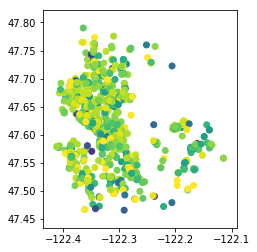

In [88]:
# Geopandas also has some convenient built-in plotting methods
# quick scatter plot colored by 'rating'
gf.plot(c=gf.rating)

## Geometric operations

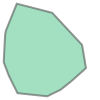

In [89]:
# We also now have access to lots of quantifiable spatial information. For example, how large
# is the area containing all these points?
#http://geopandas.org/geometric_manipulations.html
point_collection = shapely.geometry.MultiPoint(gf.geometry.tolist())
polygon = point_collection.convex_hull
polygon

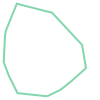

In [90]:
perimeter = polygon.boundary
perimeter

In [91]:
# You can save these geometries in a separte geodataframe as you go:
gfShape = gpd.GeoDataFrame(geometry=[polygon], crs = {'init': 'epsg:4326'})
gfShape

,geometry
0,"POLYGON ((-122.254492 47.455556, -122.3616457 ..."


**Exercise: Calculate Convex Hull**

In [59]:
def convex_hull_shape(gf):
    # a function to create the convex hull of a shape
    # ...
    # returns geopandas dataframe with the polygon shape
    return(gfShape)
    
    

## Other free geospatial tools

Geographic Information Systems (GIS) are designed for working with geospatial data. If geopandas is lacking, consider using [QGIS](https://qgis.org/en/site/). Also, [Google Earth Pro](https://www.google.com/earth/desktop/) is now free and is a great visualization tool. Finally, [GDAL/OGR](http://www.gdal.org) is a powerful library with command line tools that many other software packages are based upon.

In [93]:
# If you want to share the geometry / export it to a GIS program for further analysis:
# Default is ESRI shapefile, but Geojson or Geopackage, etc should work to
#http://geopandas.org/io.html
#http://www.geopackage.org

#gfShape.to_file('./data/myshape.shp') #ESRI shapefile is default
gfShape.to_file('./data/myshape.gpkg', driver='GPKG')

## Distance, area, etc.
 
We commonly have points in latitude and longitude, but want to know distances on the ground in meters. These conversions are non-trivial and require some knowledge of different coordinate systems and map projections. Be carefule when making these calculations!
https://support.esri.com/en/technical-article/000011356

In [94]:
# We digress... what about that question about area?
# Step 1) convert to a local coordinate system in metric units of distance!

# Google Mercator (EPSG:3857 - https://epsg.io/3857) is another popular 
# projection for web maps, but it is "direction preserving", not "area preserving!"

# A good choice for local distances is the Universal Transverse Mercator
# projection. For Seattle it's EPSG:32610
# http://spatialreference.org/ref/epsg/wgs-84-utm-zone-10n/


gfShape.to_crs({'init': 'epsg:32610'}, inplace=True)

In [95]:
# will be in units of km^2
area = gfShape.area.values[0] * 1e-6
print(f'Points are within an area of {area:.1f} km^2')

Points are within an area of 600.0 km^2


In [97]:
# Exercise:
# Calculate the length of the perimeter

In [98]:
dfD = gpd.pd.read_csv('./data/Dist_Out.csv')

In [99]:
dfD.head()

,class,departure_time,distance.value,duration.value,duration_in_traffic.value,end_lat,end_lon,fare.value,mode,origin,pair,place_id,rank,start_lat,start_lon,status
0,hospital,2018-06-06 12:41:26,1.475451,32.183333,NaN,47.716034,-122.312230,NaN,walking,530330001003,530330001003-ChIJEerXpl0RkFQRDOjfwBQDzlA,ChIJEerXpl0RkFQRDOjfwBQDzlA,1,47.72281,-122.28945,OK
1,cafe,2018-06-06 12:41:26,0.430702,9.133333,NaN,47.719859,-122.295224,NaN,walking,530330001003,530330001003-ChIJ17BqS3sRkFQR31AY2_7b1Vg,ChIJ17BqS3sRkFQR31AY2_7b1Vg,1,47.72281,-122.28945,OK
2,pharmacy,2018-06-06 12:41:26,0.494717,10.200000,NaN,47.719527,-122.295845,NaN,walking,530330001003,530330001003-ChIJ8fdfu2QRkFQRvoCQ1-nxHo0,ChIJ8fdfu2QRkFQRvoCQ1-nxHo0,2,47.72281,-122.28945,OK
3,pharmacy,2018-06-06 12:41:26,0.167185,3.416667,NaN,47.723967,-122.292140,NaN,walking,530330001003,530330001003-ChIJi_xMRXoRkFQRhfEsI71aRq8,ChIJi_xMRXoRkFQRhfEsI71aRq8,1,47.72281,-122.28945,OK
4,pharmacy,2018-06-06 12:41:26,0.812306,16.483333,NaN,47.733500,-122.291991,NaN,walking,530330001003,530330001003-ChIJKXaRMp4RkFQRr9i6RGtJ8Uo,ChIJKXaRMp4RkFQRr9i6RGtJ8Uo,3,47.72281,-122.28945,OK


In [100]:
dfD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 16 columns):
class                        15000 non-null object
departure_time               15000 non-null object
distance.value               15000 non-null float64
duration.value               15000 non-null float64
duration_in_traffic.value    0 non-null float64
end_lat                      15000 non-null float64
end_lon                      15000 non-null float64
fare.value                   2891 non-null float64
mode                         15000 non-null object
origin                       15000 non-null int64
pair                         15000 non-null object
place_id                     15000 non-null object
rank                         15000 non-null int64
start_lat                    15000 non-null float64
start_lon                    15000 non-null float64
status                       15000 non-null object
dtypes: float64(8), int64(2), object(6)
memory usage: 1.8+ MB


In [101]:
# Indexing is the same as with pandas:
dfD.iloc[0]

class                                                        hospital
departure_time                                    2018-06-06 12:41:26
distance.value                                                1.47545
duration.value                                                32.1833
duration_in_traffic.value                                         NaN
end_lat                                                        47.716
end_lon                                                      -122.312
fare.value                                                        NaN
mode                                                          walking
origin                                                   530330001003
pair                         530330001003-ChIJEerXpl0RkFQRDOjfwBQDzlA
place_id                                  ChIJEerXpl0RkFQRDOjfwBQDzlA
rank                                                                1
start_lat                                                     47.7228
start_lon           

In [102]:
# 'distance.value in the table is route distance, what about straight-line distance?
# we already have destination (place_id) lon,lat points in the earlier geodataframe 'gf'
row = 0
dest = dfD.place_id.iloc[row]

gf.query('place_id == @dest')

,name,address,city,lat,lng,place_id,rating,place_class,type,geometry
313,Elevated Natural Health,12000 15th Avenue Northeast Suite C,Seattle,47.716034,-122.31223,ChIJEerXpl0RkFQRDOjfwBQDzlA,5.0,hospital,NaN,POINT (-122.3122296 47.7160344)


In [103]:
# So let's use the start_lat, start_lon for the points in this second geodataframe
geometries = [shapely.geometry.Point(xy) for xy in zip(dfD.start_lon, dfD.start_lat)]
crs = {'init': 'epsg:4326'}
gfD = gpd.GeoDataFrame(dfD, crs=crs, geometry=geometries)

In [104]:
dfD.iloc[0]

class                                                        hospital
departure_time                                    2018-06-06 12:41:26
distance.value                                                1.47545
duration.value                                                32.1833
duration_in_traffic.value                                         NaN
end_lat                                                        47.716
end_lon                                                      -122.312
fare.value                                                        NaN
mode                                                          walking
origin                                                   530330001003
pair                         530330001003-ChIJEerXpl0RkFQRDOjfwBQDzlA
place_id                                  ChIJEerXpl0RkFQRDOjfwBQDzlA
rank                                                                1
start_lat                                                     47.7228
start_lon           

In [105]:
# To get distance let's convert once again to UTM
# Or UTM EPSG:32610
gf_merc = gf.to_crs({'init': 'epsg:32610'})
gfD_merc = gfD.to_crs({'init': 'epsg:32610'})

In [106]:
type(gf_merc)

geopandas.geodataframe.GeoDataFrame

In [107]:
# Let's do a sanity check for distance for this first pair:
pointDest = gf_merc.query('place_id == @dest').geometry.values[0]
print(pointDest)
print(pointDest.coords)


POINT (551585.3758357617 5284968.473739896)


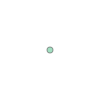

In [108]:
pointDest

In [110]:
pointOrig = gfD_merc.geometry.iloc[0]
pointOrig.coords.xy

(array('d', [553287.0140557075]), array('d', [5285736.936265724]))

In [111]:
dist_m = pointDest.distance(pointOrig)
print(f'Distance in meters: {dist_m:.1f}')
dist_mi = dist_m/1609.34
print(f'Distance in miles: {dist_mi:.1f}')

Distance in meters: 1867.1
Distance in miles: 1.2


In [112]:
# measuring the straight line distance in google earth i get (1.87 km, 1.16 miles)
# Does this make sense? if this is a walking trip that the reported distances would be a bit larger!

In [113]:
# Excercise: save the Start Point, End Point, and Straight Line between
# them to view in Google Earth


In [114]:
# That was kind of complicated for one point, but it's now easy to get all the 
# straight-line distances between origins and a particular destination:
pId = 'ChIJEerXpl0RkFQRDOjfwBQDzlA'
pointDest = gf_merc.query('place_id == @pId').geometry.values[0]
gfDest = gfD_merc.query('place_id == @pId')
gfDest
# NOTE: lots of the same origin-id. Is that the same person?

,class,departure_time,distance.value,duration.value,duration_in_traffic.value,end_lat,end_lon,fare.value,mode,origin,pair,place_id,rank,start_lat,start_lon,status,geometry
0,hospital,2018-06-06 12:41:26,1.475451,32.183333,NaN,47.716034,-122.31223,NaN,walking,530330001003,530330001003-ChIJEerXpl0RkFQRDOjfwBQDzlA,ChIJEerXpl0RkFQRDOjfwBQDzlA,1,47.72281,-122.28945,OK,POINT (553287.0140557075 5285736.936265724)
25,hospital,2018-06-06 12:41:27,1.574891,13.633333,NaN,47.716034,-122.31223,NaN,bicycling,530330001003,530330001003-ChIJEerXpl0RkFQRDOjfwBQDzlA,ChIJEerXpl0RkFQRDOjfwBQDzlA,1,47.72281,-122.28945,OK,POINT (553287.0140557075 5285736.936265724)
50,hospital,2018-06-06 12:41:27,1.574891,6.700000,NaN,47.716034,-122.31223,NaN,driving,530330001003,530330001003-ChIJEerXpl0RkFQRDOjfwBQDzlA,ChIJEerXpl0RkFQRDOjfwBQDzlA,1,47.72281,-122.28945,OK,POINT (553287.0140557075 5285736.936265724)
75,hospital,2018-06-06 12:41:27,1.563083,12.583333,NaN,47.716034,-122.31223,2.5,transit,530330001003,530330001003-ChIJEerXpl0RkFQRDOjfwBQDzlA,ChIJEerXpl0RkFQRDOjfwBQDzlA,1,47.72281,-122.28945,OK,POINT (553287.0140557075 5285736.936265724)
100,hospital,2018-06-06 12:41:28,1.295214,27.900000,NaN,47.716034,-122.31223,NaN,walking,530330001005,530330001005-ChIJEerXpl0RkFQRDOjfwBQDzlA,ChIJEerXpl0RkFQRDOjfwBQDzlA,1,47.72293,-122.29444,OK,POINT (552912.6740573557 5285746.85115021)
125,hospital,2018-06-06 12:41:28,1.336234,11.583333,NaN,47.716034,-122.31223,NaN,bicycling,530330001005,530330001005-ChIJEerXpl0RkFQRDOjfwBQDzlA,ChIJEerXpl0RkFQRDOjfwBQDzlA,1,47.72293,-122.29444,OK,POINT (552912.6740573557 5285746.85115021)
150,hospital,2018-06-06 12:41:28,1.333748,5.316667,NaN,47.716034,-122.31223,NaN,driving,530330001005,530330001005-ChIJEerXpl0RkFQRDOjfwBQDzlA,ChIJEerXpl0RkFQRDOjfwBQDzlA,1,47.72293,-122.29444,OK,POINT (552912.6740573557 5285746.85115021)
175,hospital,2018-06-06 12:41:28,1.416408,10.983333,NaN,47.716034,-122.31223,2.5,transit,530330001005,530330001005-ChIJEerXpl0RkFQRDOjfwBQDzlA,ChIJEerXpl0RkFQRDOjfwBQDzlA,1,47.72293,-122.29444,OK,POINT (552912.6740573557 5285746.85115021)
400,hospital,2018-06-06 12:41:31,1.564947,31.016667,NaN,47.716034,-122.31223,NaN,walking,530330006001,530330006001-ChIJEerXpl0RkFQRDOjfwBQDzlA,ChIJEerXpl0RkFQRDOjfwBQDzlA,1,47.72512,-122.33652,OK,POINT (549754.8601332628 5285962.350292516)
425,hospital,2018-06-06 12:41:31,1.565569,10.116667,NaN,47.716034,-122.31223,NaN,bicycling,530330006001,530330006001-ChIJEerXpl0RkFQRDOjfwBQDzlA,ChIJEerXpl0RkFQRDOjfwBQDzlA,1,47.72512,-122.33652,OK,POINT (549754.8601332628 5285962.350292516)


In [115]:
gfDest.loc[:,'straightDist'] = gfDest.distance(pointDest).values/1609.34
gfDest.loc[:, ['distance.value','straightDist']]

/Users/valentina/anaconda/envs/dssg2018/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/valentina/anaconda/envs/dssg2018/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,distance.value,straightDist
0,1.475451,1.160173
25,1.574891,1.160173
50,1.574891,1.160173
75,1.563083,1.160173
100,1.295214,0.956105
125,1.336234,0.956105
150,1.333748,0.956105
175,1.416408,0.956105
400,1.564947,1.294273
425,1.565569,1.294273


# Joining databases

In [116]:
# Given these two databases share a common column (place_id), we could do an
# "attribute" join
# NOTE that the spatial information doesn't really matter in this case:
# http://geopandas.org/mergingdata.html

# Maybe we're only interested in 'departure time, distance and duration'
# for a given destination, but want to keep the location and other attributes:

columns = ('place_id','departure_time','distance.value','duration.value')
gfSubset = gfD.loc[:,columns]
gfSubset
gfPlace = gfSubset.merge(gf, on='place_id')
gfPlace

,place_id,departure_time,distance.value,duration.value,name,address,city,lat,lng,rating,place_class,type,geometry
0,ChIJEerXpl0RkFQRDOjfwBQDzlA,2018-06-06 12:41:26,1.475451,32.183333,Elevated Natural Health,12000 15th Avenue Northeast Suite C,Seattle,47.716034,-122.312230,5.0,hospital,NaN,POINT (-122.3122296 47.7160344)
1,ChIJEerXpl0RkFQRDOjfwBQDzlA,2018-06-06 12:41:27,1.574891,13.633333,Elevated Natural Health,12000 15th Avenue Northeast Suite C,Seattle,47.716034,-122.312230,5.0,hospital,NaN,POINT (-122.3122296 47.7160344)
2,ChIJEerXpl0RkFQRDOjfwBQDzlA,2018-06-06 12:41:27,1.574891,6.700000,Elevated Natural Health,12000 15th Avenue Northeast Suite C,Seattle,47.716034,-122.312230,5.0,hospital,NaN,POINT (-122.3122296 47.7160344)
3,ChIJEerXpl0RkFQRDOjfwBQDzlA,2018-06-06 12:41:27,1.563083,12.583333,Elevated Natural Health,12000 15th Avenue Northeast Suite C,Seattle,47.716034,-122.312230,5.0,hospital,NaN,POINT (-122.3122296 47.7160344)
4,ChIJEerXpl0RkFQRDOjfwBQDzlA,2018-06-06 12:41:28,1.295214,27.900000,Elevated Natural Health,12000 15th Avenue Northeast Suite C,Seattle,47.716034,-122.312230,5.0,hospital,NaN,POINT (-122.3122296 47.7160344)
5,ChIJEerXpl0RkFQRDOjfwBQDzlA,2018-06-06 12:41:28,1.336234,11.583333,Elevated Natural Health,12000 15th Avenue Northeast Suite C,Seattle,47.716034,-122.312230,5.0,hospital,NaN,POINT (-122.3122296 47.7160344)
6,ChIJEerXpl0RkFQRDOjfwBQDzlA,2018-06-06 12:41:28,1.333748,5.316667,Elevated Natural Health,12000 15th Avenue Northeast Suite C,Seattle,47.716034,-122.312230,5.0,hospital,NaN,POINT (-122.3122296 47.7160344)
7,ChIJEerXpl0RkFQRDOjfwBQDzlA,2018-06-06 12:41:28,1.416408,10.983333,Elevated Natural Health,12000 15th Avenue Northeast Suite C,Seattle,47.716034,-122.312230,5.0,hospital,NaN,POINT (-122.3122296 47.7160344)
8,ChIJEerXpl0RkFQRDOjfwBQDzlA,2018-06-06 12:41:31,1.564947,31.016667,Elevated Natural Health,12000 15th Avenue Northeast Suite C,Seattle,47.716034,-122.312230,5.0,hospital,NaN,POINT (-122.3122296 47.7160344)
9,ChIJEerXpl0RkFQRDOjfwBQDzlA,2018-06-06 12:41:31,1.565569,10.116667,Elevated Natural Health,12000 15th Avenue Northeast Suite C,Seattle,47.716034,-122.312230,5.0,hospital,NaN,POINT (-122.3122296 47.7160344)


In [71]:
# Spatial merging uses spatial relationships (“intersects”, “within” or “contains”)
# For example, let's extract points from the database for a particular neighborhood
#https://github.com/seattleio
#https://github.com/geopandas/geopandas/blob/master/examples/spatial_joins.ipynb

gfN = gpd.read_file('../data/neighborhoods.geojson')
gfN.head()

,id,city,county,nhood,nested,area,name,geometry
0,Seattle:Ballard:Loyal Heights,Seattle,King,Ballard,Loyal Heights,2.132066e+07,Loyal Heights,POLYGON ((-122.3763324293266 47.67593689108358...
1,Seattle:Ballard:Adams,Seattle,King,Ballard,Adams,2.243128e+07,Adams,POLYGON ((-122.3763324293266 47.67593689108358...
2,Seattle:Ballard:Whittier Heights,Seattle,King,Ballard,Whittier Heights,1.419569e+07,Whittier Heights,POLYGON ((-122.3763324293266 47.67593689108358...
3,Seattle:Ballard:West Woodland,Seattle,King,Ballard,West Woodland,2.219937e+07,West Woodland,POLYGON ((-122.3763324293266 47.67593689108358...
4,Seattle:Ballard:Sunset Hill,Seattle,King,Ballard,Sunset Hill,2.433562e+07,Sunset Hill,"POLYGON ((-122.40210822192 47.69766032373056, ..."


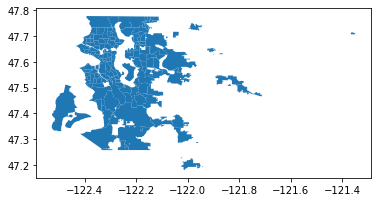

In [72]:
gfN.plot()

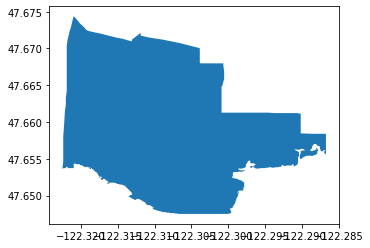

In [73]:
neighborhood = 'University District'
gfNeighborhood = gfN.query('nhood == @neighborhood')
gfNeighborhood.plot()

In [74]:
nhood_places = gpd.sjoin(gf, gfNeighborhood, how="right", op='within')
nhood_places

,index_left,name_x,address,city_x,lat,lng,place_id,rating,place_class,type,id,city_y,county,nhood,nested,area,name_y,geometry
index_right,,,,,,,,,,,,,,,,,,
5,1096,Cowen Park Grocery,1217 Northeast Ravenna Boulevard,Seattle,47.671101,-122.314426,ChIJn5m-VmQUkFQRDlqKfyUIw_8,4.2,cafe,NaN,Seattle:University District:,Seattle,King,University District,None,4.934839e+07,University District,POLYGON ((-122.2928566973496 47.66121522598398...
5,1095,Cafe Racer,5828 Roosevelt Way Northeast,Seattle,47.671466,-122.317143,ChIJZ9zbyGUUkFQRs-XXEtVUsFg,4.4,cafe,NaN,Seattle:University District:,Seattle,King,University District,None,4.934839e+07,University District,POLYGON ((-122.2928566973496 47.66121522598398...
5,1015,Mary Gates Hall Espresso,1851 Northeast Grant Lane,Seattle,47.654637,-122.307481,ChIJnwOTrfIUkFQR7uzFy_69AxU,4.1,cafe,NaN,Seattle:University District:,Seattle,King,University District,None,4.934839e+07,University District,POLYGON ((-122.2928566973496 47.66121522598398...
5,990,Husky Grind at Mercer Court,3925 Adams Lane Northeast,Seattle,47.654722,-122.317148,ChIJTwA1fPEUkFQRnLQr5-aUP0Q,3.8,cafe,NaN,Seattle:University District:,Seattle,King,University District,None,4.934839e+07,University District,POLYGON ((-122.2928566973496 47.66121522598398...
5,998,Buzz Cafe,Gould Hall (GLD),Seattle,47.654947,-122.312508,ChIJv8NnWPIUkFQRtlIKqPJOXpI,3.0,cafe,NaN,Seattle:University District:,Seattle,King,University District,None,4.934839e+07,University District,POLYGON ((-122.2928566973496 47.66121522598398...
5,1459,Starbucks,4001 East Stevens Way Northeast,Seattle,47.655297,-122.305034,ChIJd4oropIUkFQRqgtOcCXdrKU,3.0,cafe,NaN,Seattle:University District:,Seattle,King,University District,None,4.934839e+07,University District,POLYGON ((-122.2928566973496 47.66121522598398...
5,999,Bean & Bagel,1410 Northeast 40th Street,Seattle,47.655436,-122.312781,ChIJT0WJVfIUkFQR7Om-dyKcHok,4.5,cafe,NaN,Seattle:University District:,Seattle,King,University District,None,4.934839e+07,University District,POLYGON ((-122.2928566973496 47.66121522598398...
5,1613,University of Washington,NaN,NaN,47.655614,-122.305211,University-of-Washington,NaN,citywide,Major Employment Area,Seattle:University District:,Seattle,King,University District,None,4.934839e+07,University District,POLYGON ((-122.2928566973496 47.66121522598398...
5,1022,Starbucks,4000 15th Avenue Northeast,Seattle,47.655620,-122.308590,ChIJM59atfIUkFQRuY85K2cOKXk,4.0,cafe,NaN,Seattle:University District:,Seattle,King,University District,None,4.934839e+07,University District,POLYGON ((-122.2928566973496 47.66121522598398...


In [77]:
print('{} Places in {}\n'.format(len(nhood_places), neighborhood))
print(nhood_places.name_x)

# NOTE how columns with the same row were automatically dealt with by 
# appending a _left or _right suffix!

82 Places in University District

index_right
5                                   Cowen Park Grocery
5                                           Cafe Racer
5                             Mary Gates Hall Espresso
5                          Husky Grind at Mercer Court
5                                            Buzz Cafe
5                                            Starbucks
5                                         Bean & Bagel
5                             University of Washington
5                                            Starbucks
5                                      District Market
5                       Husky Grind at District Market
5                     City Grind Espresso at The Henry
5                                       By George Café
5                                        Cafe Solstice
5                                       Public Grounds
5                                            Starbucks
5                                            Parnassus
5                  

In [78]:
nhood_places.iloc[0]

index_left                                                  1096
name_x                                        Cowen Park Grocery
address                         1217 Northeast Ravenna Boulevard
city_x                                                   Seattle
lat                                                      47.6711
lng                                                     -122.314
place_id                             ChIJn5m-VmQUkFQRDlqKfyUIw_8
rating                                                       4.2
place_class                                                 cafe
type                                                         NaN
id                                  Seattle:University District:
city_y                                                   Seattle
county                                                      King
nhood                                        University District
nested                                                      None
area                     

**Exercise: neighborhood function**

In [79]:
def places_per_neighborhood(gfN, gf, neighborhood):
    # create a function which takes a geopandas dataframe of the neighborhoods,
    # geopandas dataframe of places, and a neighborhood name
    # ...
    # returns geopandas dataframe with places per neighborhood
    return(nhood_places)  
    

# Lots of directions to take this in!
- Which neighborhood has the longest travel times?
- What about ratio of straight-line distance to traveled distance?
- Export data for a particular neighborhood
- Incorporate another GIS dataset of your choosing!

# Good luck from here!